# Adam: A Method for Stochastic Optimization

This notebook implements the Adam optimizer from scratch based on the paper by Kingma and Ba (2014). We will compare its convergence properties against standard Stochastic Gradient Descent (SGD) on the MNIST dataset.

In [ ]:
!pip install torch torchvision matplotlib seaborn numpy

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Set visualization style
sns.set_theme(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Custom Adam Implementation

Here we implement the optimizer class inheriting from `torch.optim.Optimizer`. This explicitly codes Equation 1 through Equation 8 from the Adam paper.

In [3]:
class AdamFromScratch(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamFromScratch, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients')

                # L2 Regularization (Weight Decay)
                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                t = state['step']

                # Decay the first and second moment running average coefficient
                # m_t = beta1 * m_{t-1} + (1 - beta1) * g_t
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                # v_t = beta2 * v_{t-1} + (1 - beta2) * g_t^2
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                # m_hat = m_t / (1 - beta1^t)
                bias_correction1 = 1 - beta1 ** t
                m_hat = exp_avg / bias_correction1

                # v_hat = v_t / (1 - beta2^t)
                bias_correction2 = 1 - beta2 ** t
                v_hat = exp_avg_sq / bias_correction2

                # Update parameters
                # theta = theta - lr * m_hat / (sqrt(v_hat) + eps)
                denom = v_hat.sqrt().add_(group['eps'])
                step_size = group['lr']

                p.data.addcdiv_(m_hat, denom, value=-step_size)

        return loss

## 2. Dataset and Model Setup

We use MNIST (Modified National Institute of Standards and Technology), a database of handwritten digits. It serves as a standard benchmark for optimization algorithms.

In [4]:
# Download and Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                         download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Simple Multi-Layer Perceptron
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

100%|██████████| 9.91M/9.91M [00:00<00:00, 52.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.87MB/s]


## 3. Training Loop and Experiment

We define a generic training function and run two experiments:
1. Training with our **Custom Adam**.
2. Training with **Standard SGD**.

In [8]:
def train_model(optimizer_class, learning_rate, train_loader, epochs=3, name="Adam"):
    model = SimpleMLP().to(device)

    # Instantiate optimizer
    if name == "AdamFromScratch":
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    else:
        # For comparison, we use PyTorch built-in SGD
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()
    losses = []

    model.train()
    print(f"Starting training with {name}...")

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Log loss every 10 steps for smoother plotting
            if batch_idx % 10 == 0:
                losses.append(loss.item())

        print(f"Epoch {epoch+1}/{epochs} completed.")

    return losses

# Run Experiments
print("Running Adam Experiment...")
adam_losses = train_model(AdamFromScratch, learning_rate=0.001, train_loader=train_loader, epochs=2, name="AdamFromScratch")

print("Running SGD Experiment...")
sgd_losses = train_model(torch.optim.SGD, learning_rate=0.01, train_loader=train_loader, epochs=2, name="SGD")

Running Adam Experiment...
Starting training with AdamFromScratch...
Epoch 1/2 completed.
Epoch 2/2 completed.
Running SGD Experiment...
Starting training with SGD...
Epoch 1/2 completed.
Epoch 2/2 completed.


## 4. Visualization of Convergence

We compare the training loss curves. Adam typically shows faster convergence in the initial phases of training compared to standard SGD.

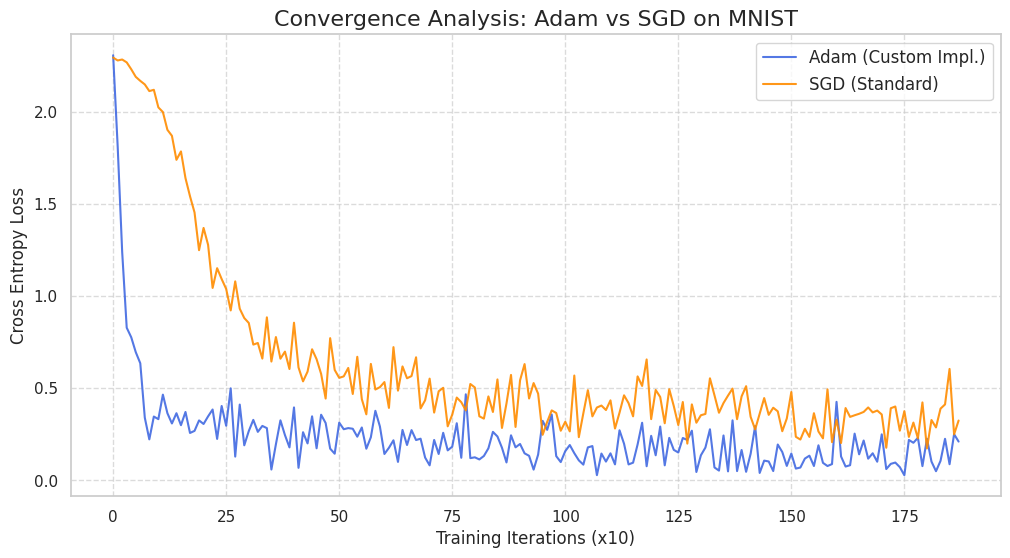

In [9]:
plt.figure(figsize=(12, 6))

# Plotting
plt.plot(adam_losses, label='Adam (Custom Impl.)', color='royalblue', alpha=0.9, linewidth=1.5)
plt.plot(sgd_losses, label='SGD (Standard)', color='darkorange', alpha=0.9, linewidth=1.5)

plt.title('Convergence Analysis: Adam vs SGD on MNIST', fontsize=16)
plt.xlabel('Training Iterations (x10)', fontsize=12)
plt.ylabel('Cross Entropy Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()